<a href="https://colab.research.google.com/github/dnguyend/par-trans/blob/main/examples/NumpyGL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workbook to test General Linear group parallel transport using numpy

This should be run under CPU run time.


In [1]:
!pip install git+https://github.com/dnguyend/par-trans

  Cloning https://github.com/dnguyend/par-trans to /tmp/pip-req-build-qnfz9wtt
  Running command git clone --filter=blob:none --quiet https://github.com/dnguyend/par-trans /tmp/pip-req-build-qnfz9wtt
  Resolved https://github.com/dnguyend/par-trans to commit 8a7b9ef3c88d929d40c9a9f990cf257132243f46
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for par-trans: filename=par_trans-0.1.dev17+g8a7b9ef-py3-none-any.whl size=32089 sha256=3c90a8618be84d42cd26df938681f9334500da20ef78e9b2d371c8ffb0b29d9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-58er0ojr/wheels/43/54/27/33e127e64ed29c538e4b5356c5a5801c527ecfa659afe8ec3c
Successfully built par-trans


May take a bit to download - after that you will see "Collecting git+..."

Import the libraries

In [2]:
from time import perf_counter

import numpy as np
import numpy.linalg as la
from numpy.random import randn

from par_trans.manifolds import GLpBeta
from par_trans.utils.utils import (sym, asym, lie, cz)

from scipy.linalg import expm
from scipy.sparse.linalg import expm_multiply, LinearOperator

Run several tests:
* check the metric compatible condition of the Levi-Civita connection. For 2 tangent vectors $v, va$, $X: z\mapsto glp.proj(z, va)$ is a vector field. We compare $D_v\langle X, X\rangle$ and $2\langle X, D_vX + \Gamma(v, X)\rangle$
* Check Geodesic and transport equations.
* The function glp.exp gives the Riemannian exponential map, while $glp.dexp(x, v, t,ddexp=True) $ computes $\gamma(t), \dot{\gamma}(t)$ and $\ddot{\gamma}(t)$ where $\gamma(t)$ is the geodesic starting at $x$ with initial velocity $\dot{\gamma}(0) = v$. If $ddexp=False$, only $\gamma$ and $\dot{\gamma}$ are returned.

We verify dexp indeed returns the time derivatives, and show the parallel transport equation is satisfied.


In [3]:

def test():
    np.random.seed(1)
    n = 5
    beta = 1.2
    glp = GLpBeta(n, beta)

    x = glp.rand_point()
    v = glp.rand_vec(x)
    va = glp.rand_vec(x)
    vb = glp.rand_vec(x)

    t = .8

    dlt = 1e-6

    print("Check Christoffel gamma produces a metric compatible connection")
    print((glp.inner(x+dlt*v, va, va) - glp.inner(x, va, va))/dlt)
    print(2*glp.inner(x, va, glp.christoffel_gamma(x, v, va)))

    print("Check time derivatives of geodesics")
    print(cz((glp.exp(x, (t+dlt)*v) - glp.exp(x, t*v))/dlt
             - glp.dexp(x, v, t, ddexp=False)[1]))

    print(cz((glp.dexp(x, v, t+dlt)[1] - glp.dexp(x, v, t)[1])/dlt
             - glp.dexp(x, v, t, ddexp=True)[2]))

    gmms = glp.dexp(x, v, t, ddexp=True)
    print("CHECK Geodesic Equation with analytic differentiation")
    print(cz(gmms[2] + glp.christoffel_gamma(gmms[0], gmms[1], gmms[1])))

    def Par(b, a):
        return 0.5*(lie(b, a) + (1+glp.beta)*(lie(asym(a), b) - lie(asym(b), a)))

    def Par_T(b, a):
        return 0.5*(lie(b, a.T) + (1+glp.beta)*(lie(-asym(a), b) - asym(lie(b, a.T))))

    print("Check Par and Par_T, the transport operator and adjoint")
    print(np.sum(Par(va, v)*vb))
    print(np.sum(Par_T(vb, v)*va))

    def sc(a, ft):
        return sym(a) + ft*asym(a)

    def par_bal(b, a):
        bnew = sc(b, 1/np.sqrt(glp.beta))
        return sc(0.5*(lie(bnew, a) + (1+glp.beta)*(lie(asym(a), bnew) - lie(asym(bnew), a))),
                  np.sqrt(glp.beta))


    def par_bal(b, a):
        bnew = sc(b, 1/np.sqrt(glp.beta))
        return sc(0.5*(lie(bnew, a) + (1+glp.beta)*(lie(asym(a), bnew) - lie(asym(bnew), a))),
                  np.sqrt(glp.beta))

    print("check scaling produces an antisymmetric operator")
    print(np.sum(sc(Par(sc(vb, 1/np.sqrt(glp.beta)), v), np.sqrt(glp.beta))*va))
    print(np.sum(sc(Par(sc(va, 1/np.sqrt(glp.beta)), v), np.sqrt(glp.beta))*vb))

    Delta = glp.parallel(x, v, va, t)

    print("CHECK TRANSPORT EQUATION with numerical differentiation")
    print((glp.parallel(x, v, va, t+dlt) - Delta)/dlt \
          + glp.christoffel_gamma(gmms[0], gmms[1], Delta))


test()

Check Christoffel gamma produces a metric compatible connection
31528.97252675757
31528.416129844147
Check time derivatives of geodesics
6.178894034203353e-06
1.993369299047032e-05
CHECK Geodesic Equation with analytic differentiation
1.846037989139404e-09
Check Par and Par_T, the transport operator and adjoint
-4.7860537387110575
-4.786053738711059
check scaling produces an antisymmetric operator
4.728565434240489
-4.728565434240487
CHECK TRANSPORT EQUATION with numerical differentiation
[[ 2.12348637e-04  6.27005402e-05  7.53241935e-05  2.83791696e-04
  -6.04082599e-04]
 [-2.36293367e-04  3.92538416e-04  5.62731723e-05  7.76836389e-04
  -4.45106179e-04]
 [ 2.28669313e-04 -2.74781763e-04 -5.86341997e-09 -4.36384965e-04
   8.09254491e-05]
 [-4.47982210e-05  9.55957016e-05  3.80797314e-05  2.59612941e-04
  -2.24384311e-04]
 [-1.98115990e-04  4.46743373e-04  3.70389387e-05  7.91797850e-04
  -4.69453388e-04]]


In [14]:
def check_time_d():
  t = 30.
  n_list = [2, 3, 4, 10, 20, 30]
  # n_list = [2, 3]
  for n in n_list:
    beta = .6
    glp = GLpBeta(n, beta)

    x = glp.rand_point()
    v = glp.rand_vec(x)
    v = v/np.sqrt(glp.inner(x, v, v))
    va = glp.rand_vec(x)
    t0 = perf_counter()
    glp.parallel(x, v, va, t)
    t1 = perf_counter()
    print("n=%d time=%f(s)" % (n, t1-t0))
check_time_d()

n=2 time=0.026921(s)
n=3 time=0.047946(s)
n=4 time=0.054385(s)
n=10 time=0.033340(s)
n=20 time=0.136079(s)
n=30 time=0.198051(s)


# TEST ISOMETRY

We show the inner product metric is preserved to around $10^{-12}$ for small $t$ but deteriorate when $t$ is higher. This is in contrast to compact manifolds such as $SO(n)$, Stiefel manifolds, flag manifold.

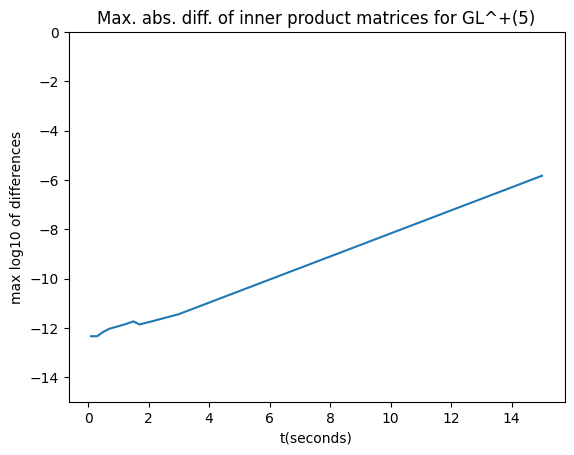

array([[  0.1       , -12.34222982],
       [  0.3       , -12.34222982],
       [  0.5       , -12.16613856],
       [  0.7       , -12.04119983],
       [  1.2       , -11.86510857],
       [  1.5       , -11.74016983],
       [  1.7       , -11.86510857],
       [  2.1       , -11.74016983],
       [  3.        , -11.44597926],
       [ 15.        ,  -5.82902971]])

In [22]:
import matplotlib.pyplot as plt
import numpy.linalg as la

np.random.seed(0)

beta = .5
n = 5
glp = GLpBeta(n, beta)

x = np.eye(glp.shape[1])

n_samples = 20

all_smpl = []

def normalize(a, x):
    return a / np.sqrt(glp.inner(x, a, a))

for _ in range(n_samples):
    spl = glp.rand_vec(x)
    ft = np.random.choice(3*n_samples, (), replace=True)

    all_smpl.append(ft*normalize(spl, x))

all_smpl = np.array(all_smpl)


def cal_cov(gm, smpls):
    mat = np.zeros((n_samples,  n_samples))
    for i in range(n_samples):
        for j in range(i+1):
            mat[i, j] = glp.inner(gm, smpls[i, :, :], smpls[j, :, :])
            if i != j:
                mat[j, i] = mat[i, j]
    return mat

cov_0 = cal_cov(x, all_smpl)

v = glp.rand_vec(x)
v = v/np.sqrt(glp.inner(x, v, v))

cov_diff = []
# t_grid = [0.5, 1., 2., 5., 10., 15.]
# t_grid = [0.5, 1.]
t_grid = [0.1, .3, .5, .7, 1.2, 1.5, 1.7, 2.1, 3., 15.]
for t in t_grid:
    transported = []
    for i in range(n_samples):
        transported.append(glp.parallel(x, v, all_smpl[i, :, :], t))

    transported = np.array(transported)
    gm = glp.exp(x, t*v)
    cov_t = cal_cov(gm, transported)
    # print(cz(cov_t- cov_0))
    cov_diff.append((t, cov_t))

plt.plot(t_grid, [np.log10(cz(cov_diff[i][1] - cov_0)) for i in range(len(cov_diff))])
plt.ylim(-15, 0)
plt.xlabel("t(seconds)")
plt.ylabel("max log10 of differences")
plt.title("Max. abs. diff. of inner product matrices for GL^+(%d)" % n)
plt.savefig("cov_diff_flag.png")
plt.show()
display(np.concatenate([np.array(t_grid)[:, None], np.array([np.log10(cz(cov_diff[i][1] - cov_0)) for i in range(len(cov_diff))])[:, None]], axis=1))

In [ ]:
from psutil import *
# This code will return the number of CPU
print("Number of CPU: ", cpu_count())
# This code will return the CPU info
!cat /proc/cpuinfo

Number of CPU:  2
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4399.99
clflush size	: 64
cache

In [ ]:
virtual_memory()

svmem(total=13609422848, available=12406104064, percent=8.8, used=868282368, free=8795402240, active=773169152, inactive=3752456192, buffers=398286848, cached=3547451392, shared=1646592, slab=221720576)